In [2]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import pickle
from collections import defaultdict
import random
import statistics as st #for the mode
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
#repeated measures correlation
import pingouin as pg

#plot
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key, chi2_distance, most_frequent
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [5]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_clustering = os.path.join(path_extracted_data_visual_adap,'clustering')
for nbr_bin in li_binmn:
    path_extracted_data_visual_adap_binmn = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability',str(nbr_bin))
    #create a director if not existing
    if not os.path.exists(path_extracted_data_visual_adap_binmn):
        os.makedirs(path_extracted_data_visual_adap_binmn)

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
li_nbr_cluster = range(2,100)
V = 'chi2distance_ALL_15'
name_clustering = 'ALL_MLPS_99'
path_extracted_data_visual_adap_clustering_V = os.path.join(path_extracted_data_visual_adap_clustering, V+'_ALL_MLPS')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [5]:
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))
#for now we have only distance restricted to 70 animals
#compute the CHI2DISTANCE & DTW for each bird with all other birds (because we need this exact same pair to do the visual)
#rv = 0
#random.seed(rv)
#nbr_hens = 70
#randomly pick more than one element from the list without repeating elements.
#li_selected_hens = random.sample(li_selected_hens, nbr_hens)

131


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#HA&KBF&weight
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
print(df_HA.shape)
df_HA = df_HA[df_HA['HenID'].isin(li_selected_hens)]
display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
print(df_HA.shape)
df_HA.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(689, 47)


,HAID,date
0,HA1,{2020-11-23 00:00:00}
1,HA2,{2021-01-04 00:00:00}
2,HA3,{2021-02-01 00:00:00}
3,HA4,{2021-04-12 00:00:00}


(458, 47)


,Person_toe,Time,PenID,FocalLegringName,Bird type,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,initial_path_img,actual_path_img,imageID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Info,backpack
1,C,08:10,pen11,26grey,NaN,50.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,399.0,493.0,32.0,0.0,26grey11sbs,NaN,"['', '26', 'grey', '11', 'sbs']",sbs
2,C,11:43,pen11,70green,normal,25.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,179.0,478.0,0.0,0.0,70green11gg,NaN,"['', '70', 'green', '11', 'gg']",gg
3,C,08:10,pen11,28green,NaN,0.0,NaN,0.0,0.0,0.0,...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,53.0,494.0,12.0,0.0,28green11ss,gap healed no more gap,"['', '28', 'green', '11', 'ss']",ss


In [7]:
df_HA[df_HA['severity'].isnull()]['HAID'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


HA2    115
Name: HAID, dtype: int64

In [8]:
#dailyMVT var
df_MVT = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed_SNA_clID.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT.shape)
df_MVT = df_MVT[df_MVT['HenID'].isin(li_selected_hens)]
#lets restrict to the adaptability study timeframe
df_MVT = df_MVT[df_MVT['level']<=config.max_date_adaptability]
df_MVT['DOA'] = df_MVT['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_MVT['WOA'] = df_MVT['DOA'].map(lambda x: math.ceil(x/7))
df_MVT['DIB'] = df_MVT['DOA'].map(lambda x: x-118)
df_MVT['WIB'] = df_MVT['DIB'].map(lambda x:  math.ceil(x/7))
print(df_MVT.shape)
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (123,135,172,173,174,175,176,177,179,180,181,182,183,184,185,186,187,188) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(42300, 223)
(6721, 225)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,Total_number_zone,Max_duration_zones,...,degree_DTW_30_2_Zone,degree_DTW_30_3_Zone,degree_DTW_30_4_Zone,degree_DTW_30_5_Zone,degree_DTW_30_all,ALL_MLPS_99,ALL_MLPS_10,ALL_MLPS_40,DIB,WIB
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,4.0,2_Zone,...,0.131944,0.208333,0.826389,0.437500,0.312500,NaN,NaN,NaN,1,1
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,3.0,5_Zone,...,0.047619,0.176871,0.802721,0.115646,0.380952,NaN,NaN,NaN,2,1
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,2.0,5_Zone,...,0.564626,0.646259,0.802721,0.455782,0.503401,NaN,NaN,NaN,3,1


# Processing

In [9]:
#make sure np.nan for wintergarten var!!
df_MVT.loc[df_MVT['level']<config.date_first_opening_WG,'percentage_time_outside_while_WG_open'] = np.nan
df_MVT.loc[df_MVT['level']<config.date_first_opening_WG,'latency_1_Zone'] = np.nan
#small check
#df_MVT[df_MVT['HenID']=='hen_10'][['level','duration_5_Zone','percentage_time_outside_while_WG_open','latency_1_Zone']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#compeck: HA1: as worse time for this
#overall pododeratitis: should be worst over time, so only HA4
df_HA['Injuries'] = df_HA.apply(lambda x: x['LFinjuries']+x['RFinjuries'], axis=1)
df_HA['Pododermatitis'] = df_HA.apply(lambda x: x['RFPododermatitis']+x['LFPododermatitis'], axis=1)
df_HA['Pododermatitis_bin'] = df_HA['Pododermatitis'].map(lambda x: int(x>100))
df_HA['Bumblefoot'] = df_HA.apply(lambda x: x['LFBumblefoot']+x['RFBumblefoot'], axis=1)
df_HA['BumblefootMax'] = df_HA.apply(lambda x: max(x['LFBumblefoot'],x['RFBumblefoot']), axis=1)

#overall feather as in eneral have the same tendency: only from HA4: as should be worse over time
df_HA['Feathers'] = df_HA.apply(lambda x: np.mean([x['BreastFeather'],x['CloacaFeather'],
                                                   x['WingFeather'],x['TailFeather']]), axis=1)
display(df_HA[df_HA['Feathers'].isnull()].shape)
display(df_HA[~df_HA['Feathers'].isnull()].shape)
df_HA.head(3)

In [11]:
#add np.nan for the WG var when the WG was close
df_MVT['in_WG_15mnAfterOpening_whenopen'] = df_MVT.apply(lambda x: x['in_WG_15mnAfterOpening'] if x['level']>config.date_first_opening_WG else np.nan, axis=1)
display(df_MVT['in_WG_15mnAfterOpening'].value_counts())
display(df_MVT['in_WG_15mnAfterOpening_whenopen'].value_counts())
df_MVT.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    5211
1.0    1171
Name: in_WG_15mnAfterOpening, dtype: int64

0.0    4358
1.0    1171
Name: in_WG_15mnAfterOpening_whenopen, dtype: int64

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,Total_number_zone,Max_duration_zones,...,degree_DTW_30_3_Zone,degree_DTW_30_4_Zone,degree_DTW_30_5_Zone,degree_DTW_30_all,ALL_MLPS_99,ALL_MLPS_10,ALL_MLPS_40,DIB,WIB,in_WG_15mnAfterOpening_whenopen
0,hen_1,2020-09-30,0.0,18886.0,3488.0,515.0,5911.0,28800.0,4.0,2_Zone,...,0.208333,0.826389,0.437500,0.312500,NaN,NaN,NaN,1,1,NaN
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,3.0,5_Zone,...,0.176871,0.802721,0.115646,0.380952,NaN,NaN,NaN,2,1,NaN
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,2.0,5_Zone,...,0.646259,0.802721,0.455782,0.503401,NaN,NaN,NaN,3,1,NaN


In [12]:
#add dib etc and save
df_MVT = df_MVT[~df_MVT['perc_duration_5_Zone'].isnull()]
for v in ['perc_duration_5_Zone','perc_duration_4_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone']:
    df_MVT[v] = df_MVT[v].astype(int)
df_MVT['PenID'] = df_MVT['PenID'].map(lambda x: 'pen'+str(int(x)))
df_MVT['TrackingSystemID'] = df_MVT['PenID'].map(lambda x: config.dico_pen_ts[x])
display(df_MVT['TrackingSystemID'].value_counts())
#per hour, as at the begining the barn schedule change
df_MVT['vertical_travel_distance_perh'] = df_MVT.apply(lambda x: x['vertical_travel_distance']/(x['nbr_sec_per_day']/60/60), axis=1)
display(df_MVT[['vertical_travel_distance_perh','vertical_travel_distance', 'nbr_sec_per_day']].head(3))
df_MVT.to_csv(os.path.join(path_extracted_data ,'df_MVT_4repeatibility.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TrackingSystem 10-12    2645
TrackingSystem 3-5      2170
TrackingSystem 8-9      1567
Name: TrackingSystemID, dtype: int64

,vertical_travel_distance_perh,vertical_travel_distance,nbr_sec_per_day
0,0.875000,7.0,28800.0
1,2.000000,18.0,32400.0
2,0.444444,4.0,32400.0


c('nbr_days_4zonevisited','nbr_days_nomvt','Treatment','mean_perc_duration_5_Zone','mean_perc_duration_3_Zone',
         'mean_perc_duration_2_Zone','mean_percentage_time_outside_while_WG_open','mean_vertical_travel_distance_perh')

df_ = df_MVT[df_MVT['DIB'].isin([50,54])].groupby(['HenID'])['perc_duration_2_Zone'].agg(lambda x: list(x)).reset_index()
df_['nbrobs'] = df_['perc_duration_2_Zone'].map(lambda x: len(x))
df_[df_['nbrobs']!=2]
df_ = df_MVT[df_MVT['DIB'].isin([2,7+2])].groupby(['HenID'])['vertical_travel_distance_perh'].agg(lambda x: list(x)).reset_index()
df_['nbrobs'] = df_['vertical_travel_distance_perh'].map(lambda x: len(x))
df_

# Chosing variables

In [13]:
dico_h_penid = dict(zip(df_HA['HenID'].tolist(), df_HA['PenID'].tolist()))
dico_h_tr = dict(zip(df_HA['HenID'].tolist(), df_HA['Treatment'].tolist()))

li_mvt4MLPs = ['perc_duration_5_Zone','perc_duration_4_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone',
               'percentage_time_outside_while_WG_open', 'latency_1_Zone', 'vertical_travel_distance_perh']
li_ha = ['severity','Feathers','Pododermatitis','Pododermatitis_bin','BumblefootMax','Bumblefoot','Person_toe','Person_feather']
HAID = 'HA4'

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# MLP ~ HA (one obs per hen)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


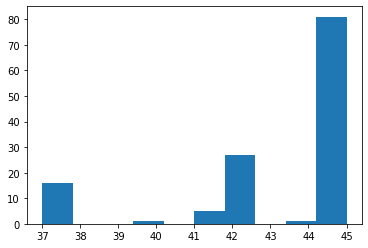

(131, 9)
(131, 30)
(98, 38)


In [14]:
#MSSD (Mean of the squared successive differences)
#It is calculated by taking the sum of the differences between consecutive observations squared, then taking the mean of that sum and dividing by two.
def mssd(li, maxnbr_nan=None):
    li_diff = [(li[i+1]-li[i])**2 for i in range(0,len(li)-1) if (math.isnan(li[i+1])==False)&(math.isnan(li[i])==False)]
    #return NA if to many nan
    if maxnbr_nan!=None:
        if (len(li)-len(li_diff))>=maxnbr_nan:
            return(np.nan)
    return(np.mean(li_diff)/2)
df_MLPandHA = df_MVT[df_MVT['WIB']!=1].groupby(['HenID'])[li_mvt4MLPs].agg(lambda x: list(x)).reset_index()
df_MLPandHA['nbr_obs'] = df_MLPandHA[li_mvt4MLPs[0]].map(lambda x: len(x))
plt.hist(df_MLPandHA['nbr_obs'])
plt.show()
print(df_MLPandHA.shape)
#df_MLPandHA = df_MLPandHA[df_MLPandHA['nbr_obs']>=52]
#compute mssd and the mean
for var in li_mvt4MLPs:
    df_MLPandHA['mssd_'+var] = df_MLPandHA[var].map(lambda x: mssd(x))
    df_MLPandHA['mean_'+var] = df_MLPandHA[var].map(lambda x: np.nanmean(x))
    df_MLPandHA['nbr_obs_'+var] = df_MLPandHA[var].map(lambda x: len([i for i in x if not math.isnan(i)]))
#add HA results
print(df_MLPandHA.shape)
df_MLPandHA = pd.merge(df_MLPandHA, df_HA[df_HA['HAID']==HAID][['HenID']+li_ha], on=['HenID'], how='inner')
print(df_MLPandHA.shape)
df_MLPandHA['PenID'] = df_MLPandHA['HenID'].map(lambda x: dico_h_penid[x])
df_MLPandHA['Treatment'] = df_MLPandHA['HenID'].map(lambda x: dico_h_tr[x])
#df_MLPandHA[[x for x in df_MLPandHA.columns if x.startswith('mssd')|(x.startswith('mean'))]+['severity','Feathers','perc_days_nomvtamngfirst3days']].to_csv(os.path.join(path_extracted_data ,'Adaptability_Stat_MSSD_mixedeffect_R.csv'), index=False, sep=';')

In [15]:
li_nbr_obs = [x for x in df_MLPandHA.columns if x.startswith('nbr_obs_')]
li_nbr_obs

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['nbr_obs_perc_duration_5_Zone',
 'nbr_obs_perc_duration_4_Zone',
 'nbr_obs_perc_duration_3_Zone',
 'nbr_obs_perc_duration_2_Zone',
 'nbr_obs_percentage_time_outside_while_WG_open',
 'nbr_obs_latency_1_Zone',
 'nbr_obs_vertical_travel_distance_perh']

In [16]:
df_MLPandHA[li_nbr_obs]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,nbr_obs_perc_duration_5_Zone,nbr_obs_perc_duration_4_Zone,nbr_obs_perc_duration_3_Zone,nbr_obs_perc_duration_2_Zone,nbr_obs_percentage_time_outside_while_WG_open,nbr_obs_latency_1_Zone,nbr_obs_vertical_travel_distance_perh
0,45,45,45,45,44,44,45
1,37,37,37,37,36,36,37
2,42,42,42,42,41,41,42
3,45,45,45,45,44,44,45
4,44,44,44,44,43,43,44
...,...,...,...,...,...,...,...
93,42,42,42,42,41,41,42
94,45,45,45,45,44,44,45
95,42,42,42,42,41,41,42
96,45,45,45,45,44,44,45


In [17]:
df_MLPandHA['Bumblefoot'].value_counts() #wont use it!

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0    97
1.0     1
Name: Bumblefoot, dtype: int64

In [18]:
df_MLPandHA['Pododermatitis_bin'].value_counts() #wont use it!

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    72
1    26
Name: Pododermatitis_bin, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([34., 17., 10., 11., 11.,  6.,  2.,  5.,  0.,  2.]),
 array([  0. ,  26.5,  53. ,  79.5, 106. , 132.5, 159. , 185.5, 212. ,
        238.5, 265. ]),
 <BarContainer object of 10 artists>)

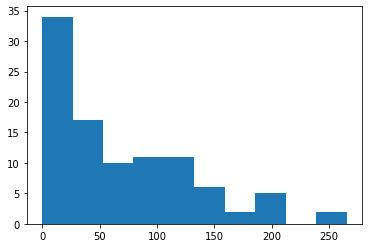

In [19]:
plt.hist(df_MLPandHA['Pododermatitis'])

In [20]:
#%of days with no movement on the first 3 days (as after a lot of missing data)
df_nnmvt = df_MVT[df_MVT['DIB'].isin([1,2,3])].groupby(['HenID','PenID'])['Total_number_zone'].agg(lambda x: list(x)).reset_index()
df_nnmvt['nbr_days'] = df_nnmvt['Total_number_zone'].map(lambda x: len(x))
display(df_nnmvt['nbr_days'].value_counts())
df_nnmvt['nbr_days_nomvt'] = df_nnmvt['Total_number_zone'].map(lambda x: sum([i==1 for i in x]))
df_nnmvt['veri=1'] = df_nnmvt['Total_number_zone'].map(lambda x: [i==1 for i in x])
display(df_nnmvt.head(3))
dico_henID_daysnomvt = dict(zip(df_nnmvt['HenID'], df_nnmvt['nbr_days_nomvt']))
#dico_henID_daysnomvt
df_nnmvt['has_nomvt_at_leastoneday'] = df_nnmvt['nbr_days_nomvt'].map(lambda x: x>0)
df_nnmvt['nbr_days_4zonevisited'] = df_nnmvt['Total_number_zone'].map(lambda x: sum([i==4 for i in x]))
#small test
if df_nnmvt[df_nnmvt['nbr_days']!=3].shape[0]>0:
    print('ERROR: you have hens that had no data on one of the first 3 days')
    sys.exit()
display(df_nnmvt.head(3))
print(df_MLPandHA.shape, df_nnmvt.shape)
df_MLPandHA = pd.merge(df_MLPandHA, df_nnmvt[['HenID','nbr_days_4zonevisited','nbr_days_nomvt']], on=['HenID'], how='inner')
#save
print(df_MLPandHA.shape)
df_MLPandHA.to_csv(os.path.join(path_extracted_data ,'Adaptability_Stat.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    131
Name: nbr_days, dtype: int64

,HenID,PenID,Total_number_zone,nbr_days,nbr_days_nomvt,veri=1
0,hen_1,pen9,"[4.0, 3.0, 2.0]",3,0,"[False, False, False]"
1,hen_10,pen11,"[4.0, 2.0, 1.0]",3,1,"[False, False, True]"
2,hen_101,pen5,"[2.0, 2.0, 3.0]",3,0,"[False, False, False]"


,HenID,PenID,Total_number_zone,nbr_days,nbr_days_nomvt,veri=1,has_nomvt_at_leastoneday,nbr_days_4zonevisited
0,hen_1,pen9,"[4.0, 3.0, 2.0]",3,0,"[False, False, False]",False,1
1,hen_10,pen11,"[4.0, 2.0, 1.0]",3,1,"[False, False, True]",True,1
2,hen_101,pen5,"[2.0, 2.0, 3.0]",3,0,"[False, False, False]",False,0


(98, 40) (131, 8)
(98, 42)


In [21]:
df_MLPandHA[['HenID','mean_percentage_time_outside_while_WG_open','nbr_obs_percentage_time_outside_while_WG_open']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,mean_percentage_time_outside_while_WG_open,nbr_obs_percentage_time_outside_while_WG_open
0,hen_10,0.852542,44
1,hen_101,5.919845,36
2,hen_102,2.397730,41


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


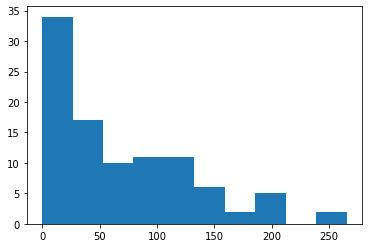

In [22]:
plt.hist(df_MLPandHA['Pododermatitis']);

In [23]:
df_MLPandHA['nbr_obs_percentage_time_outside_while_WG_open'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


44    60
41    19
36    13
40     4
43     1
39     1
Name: nbr_obs_percentage_time_outside_while_WG_open, dtype: int64

In [47]:
df_MVT[['level','DIB','WIB']].head(10)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,DIB,WIB
0,2020-09-30,1,1
1,2020-10-01,2,1
2,2020-10-02,3,1
6,2020-10-06,7,1
7,2020-10-07,8,2
8,2020-10-10,11,2
9,2020-10-11,12,2
10,2020-10-12,13,2
11,2020-10-13,14,2
12,2020-10-14,15,3


# MLP ~ short-term & long term MLPS

In [18]:
def pearsonr_ci(x, y, alpha=0.05):
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return (r, p, lo, hi)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
li_DOA = [int(x) for x in  df_MVT['DOA'].unique()]
li_df = []
li_mvt4MLPs_ = ['perc_duration_5_Zone', 'perc_duration_3_Zone', 'perc_duration_2_Zone',
               'vertical_travel_distance_perh']
for type_ in tqdm.tqdm(li_mvt4MLPs_):
    df_pivot = df_MVT.pivot(index='HenID', values=type_, columns='DOA').reset_index()
    for d1 in range(min(li_DOA),max(li_DOA)):
        for d2 in range(d1+1,max(li_DOA)+1):
            if (d2 in li_DOA)&(d1 in li_DOA):
                df_ = df_pivot.copy()
                df_ = df_.dropna(subset=[d1,d2])
                if df_.shape[0]>80:
                    df_['treatment'] = df_['HenID'].map(lambda x: dico_h_tr.get(x,np.nan))
                    #print(df_.shape)
                    #alltogether
                    coeff, p_val = pearsonr(df_[d1].tolist(), df_[d2].tolist())
                    coeff_np, p_val_np = spearmanr(df_[d1].tolist(), df_[d2].tolist())
                    r, p, lo, hi = pearsonr_ci(np.array(df_[d1].tolist()), np.array(df_[d2].tolist()))
                    li_df.append({'coeff':coeff, 'p_val':p_val, 'd1':d1, 'd2':d2, 'diff':d2-d1,
                                      'type_':type_,'nbr_obs':df_.shape[0], 'coeff_np':coeff_np, 'p_val_np':p_val_np,
                                      'L':lo, 'H':hi, 'verif':(r,p),'treatment':'alltogether'})   
                    for tr,df__ in df_.groupby(['treatment']):
                        coeff, p_val = pearsonr(df__[d1].tolist(), df__[d2].tolist())
                        coeff_np, p_val_np = spearmanr(df__[d1].tolist(), df__[d2].tolist())
                        r, p, lo, hi = pearsonr_ci(np.array(df__[d1].tolist()), np.array(df__[d2].tolist()))
                        li_df.append({'coeff':coeff, 'p_val':p_val, 'd1':d1, 'd2':d2, 'diff':d2-d1,
                                      'type_':type_,'nbr_obs':df__.shape[0],'coeff_np':coeff_np, 'p_val_np':p_val_np,
                                      'L':lo, 'H':hi, 'verif':(r,p),'treatment':tr})   
                else:
                    #print('--------------- not enough data')
                    #print(df_.shape)
                    #print(d1,d2)
                    pass
df_corrddx = pd.DataFrame(li_df)
df_corrddx['significant'] = df_corrddx['p_val'].map(lambda x: x<0.05)
print(df_corrddx.shape)
display(df_corrddx.head(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.23s/it]

(14664, 14)


,coeff,p_val,d1,d2,diff,type_,nbr_obs,coeff_np,p_val_np,L,H,verif,treatment,significant
0,0.630300,7.226590e-16,119,120,1,perc_duration_5_Zone,131,0.635870,3.353559e-16,0.514386,0.723595,"(0.6302995617007603, 7.226589939310375e-16)",alltogether,True
1,0.591548,2.114266e-07,119,120,1,perc_duration_5_Zone,65,0.604135,9.914633e-08,0.406264,0.730109,"(0.591548316519095, 2.114266248942659e-07)",OFH,True
2,0.708508,4.045423e-11,119,120,1,perc_duration_5_Zone,65,0.701976,7.269987e-11,0.561668,0.812077,"(0.7085083158193257, 4.0454233649590636e-11)",TRAN,True
3,0.534893,4.664447e-11,119,121,2,perc_duration_5_Zone,131,0.538077,3.403924e-11,0.400074,0.647053,"(0.5348934301949145, 4.664446500824274e-11)",alltogether,True
4,0.453001,1.511795e-04,119,121,2,perc_duration_5_Zone,65,0.475979,6.137962e-05,0.235074,0.627563,"(0.4530006900867973, 0.00015117945792227636)",OFH,True


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


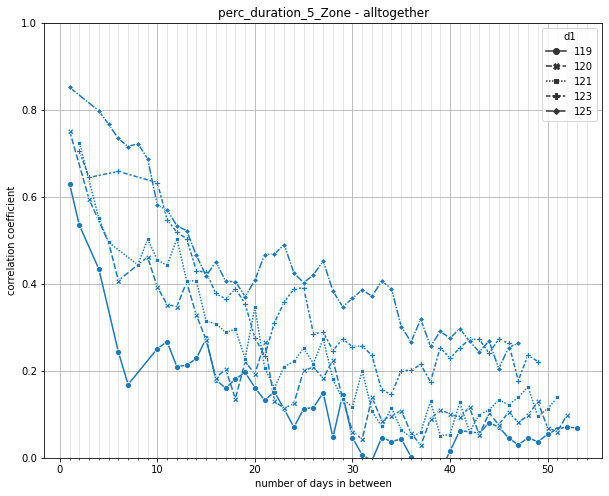

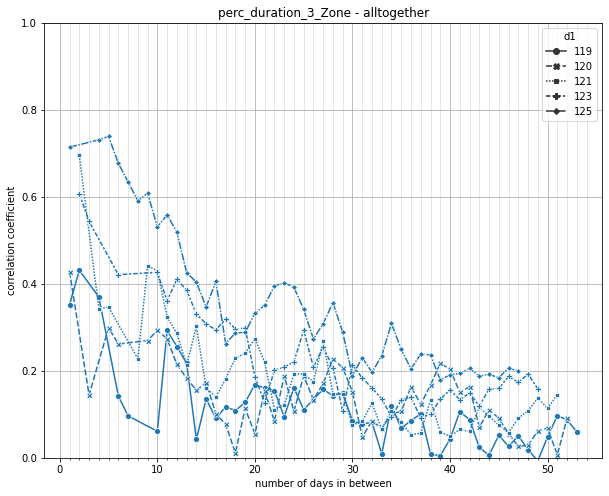

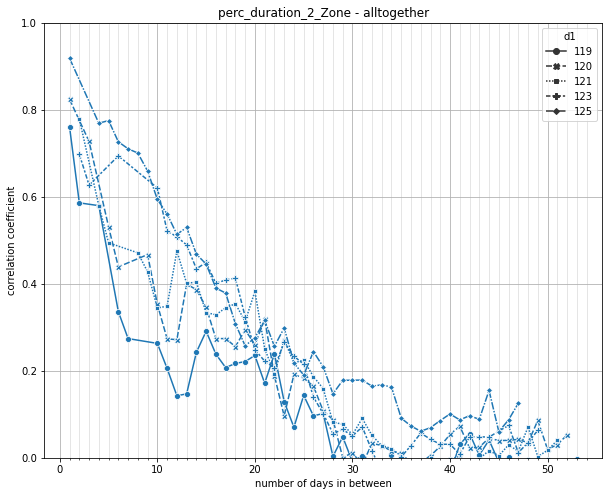

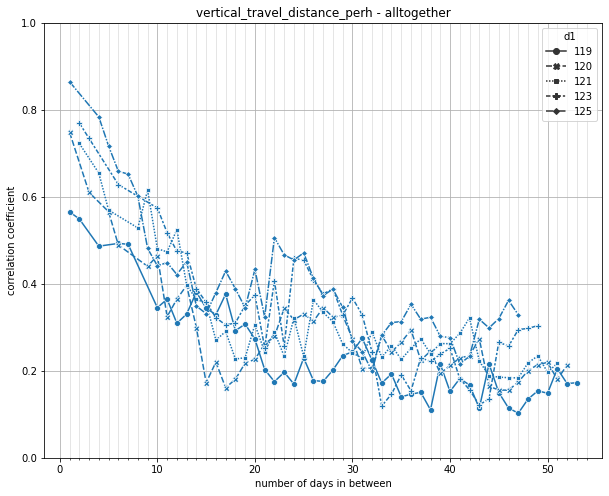

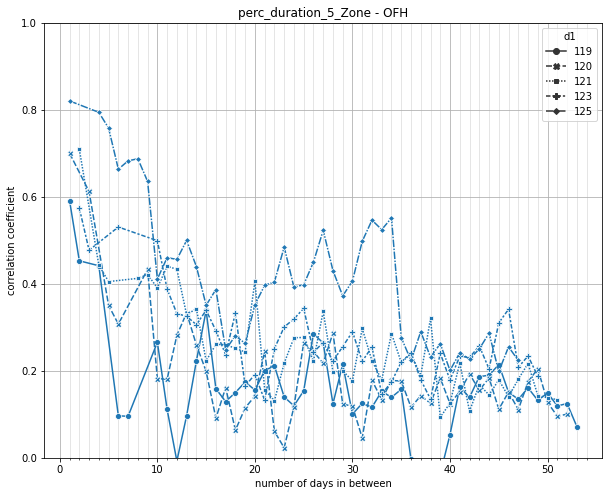

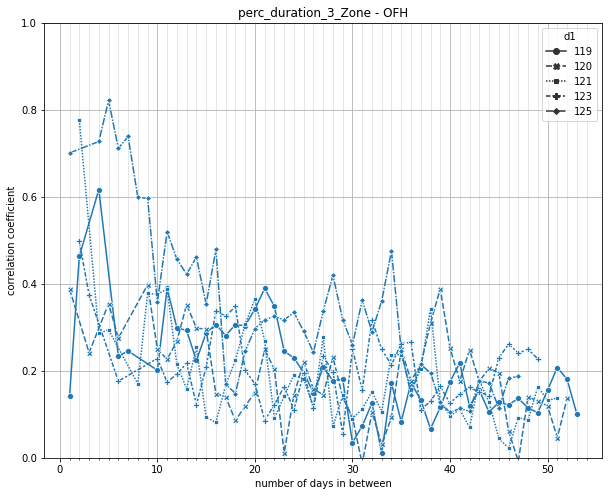

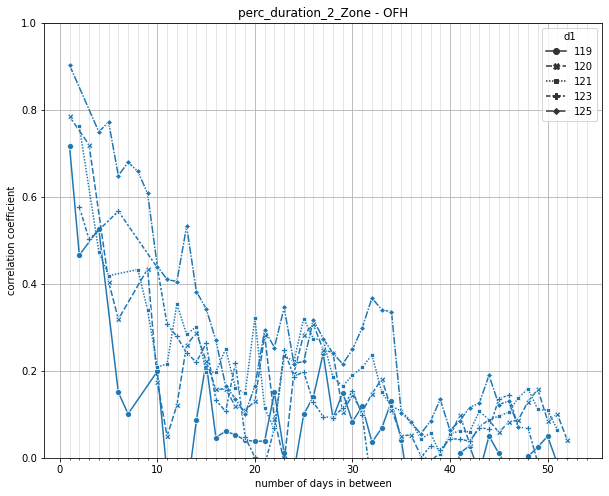

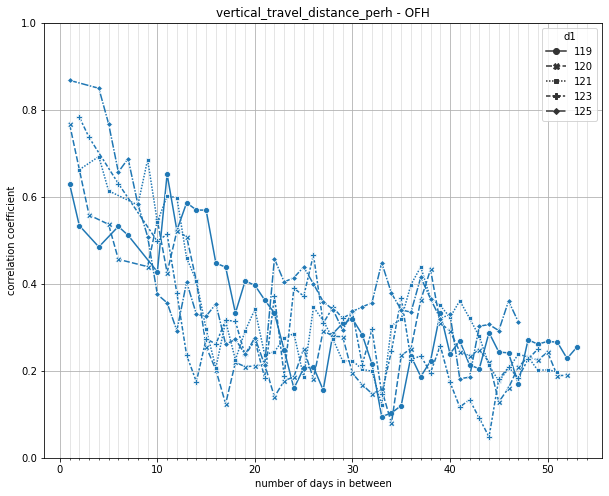

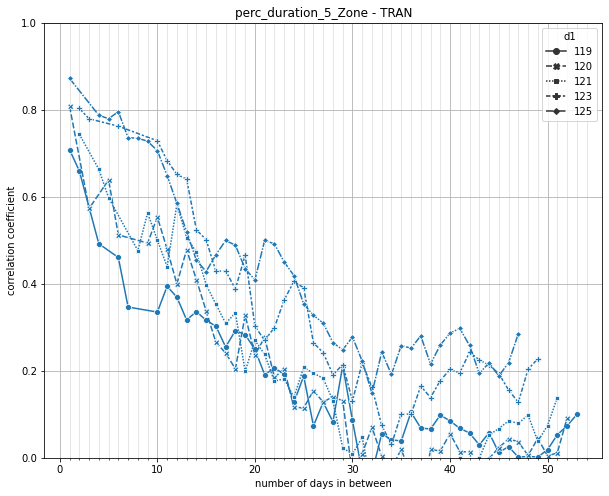

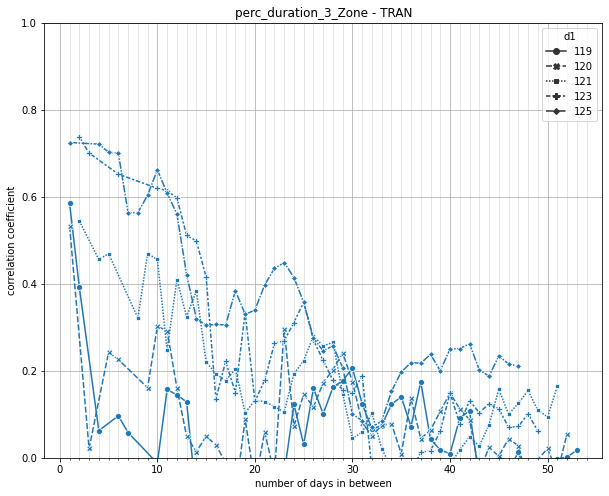

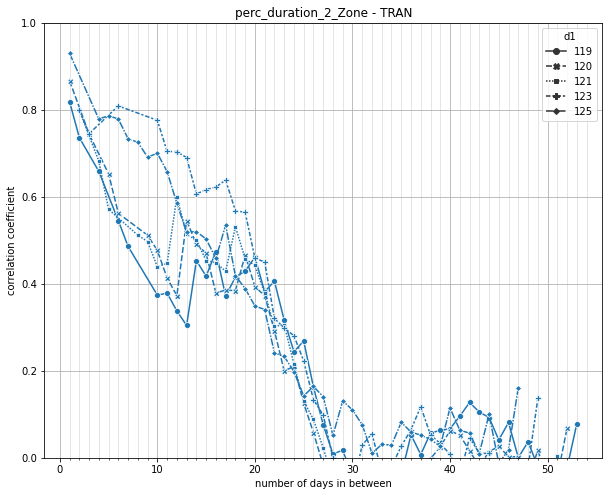

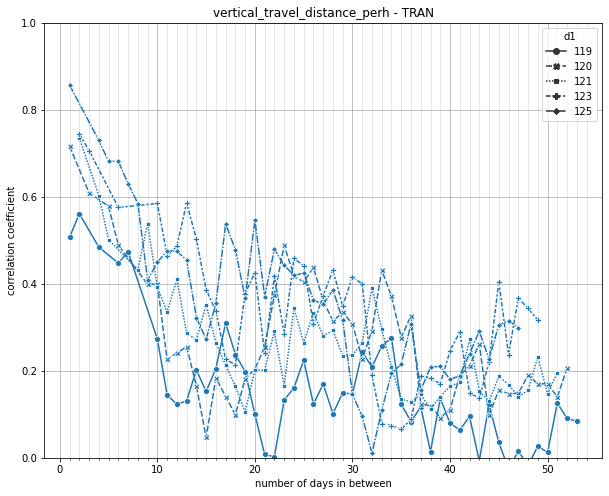

In [20]:
#nbr of "starting days" to be involved
nbr_starting_days = 7
for tr in df_corrddx['treatment'].unique():
    for type_ in df_corrddx['type_'].unique():
        fig = plt.figure(figsize=(10,8))
        plt.grid()
        graph = sns.lineplot(x='diff', y='coeff', data=df_corrddx[(df_corrddx['d1']<(min(li_DOA)+nbr_starting_days))&\
                                                                  (df_corrddx['type_']==type_)&\
                                                                  (df_corrddx['treatment']==tr)], 
                             markers=True, style='d1', hue_order=list(range(119,min(li_DOA)+nbr_starting_days)));
        plt.xlabel('number of days in between')
        plt.ylabel('correlation coefficient')
        minor_ticks = np.arange(0, 55, 1)
        graph.set_xticks(minor_ticks, minor=True)
        graph.grid(which='minor', alpha=0.4)
        plt.title(type_+' - '+tr)
        plt.ylim((0,1))
        plt.savefig(os.path.join(path_extracted_data, 'Correlation_MLPSdayx_MLPSdy_'+type_+'_'+tr+'.png'), dpi=300, format='png', 
                    bbox_inches='tight')
        plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


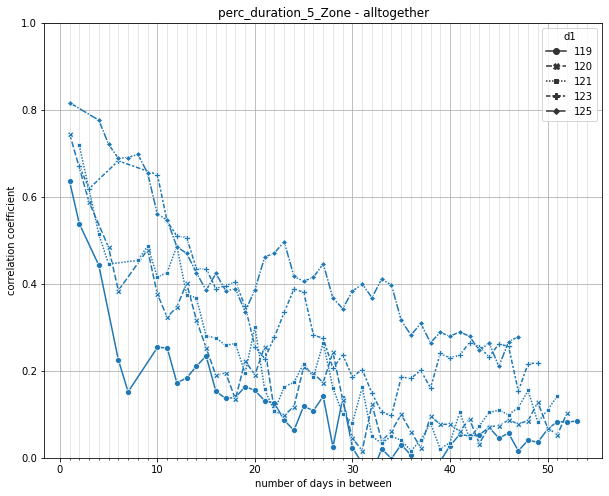

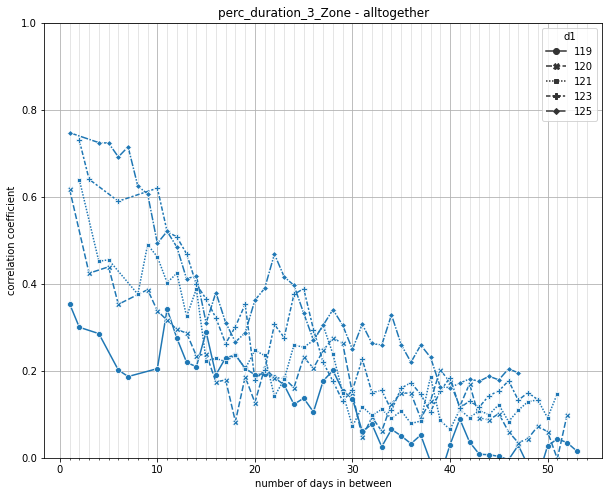

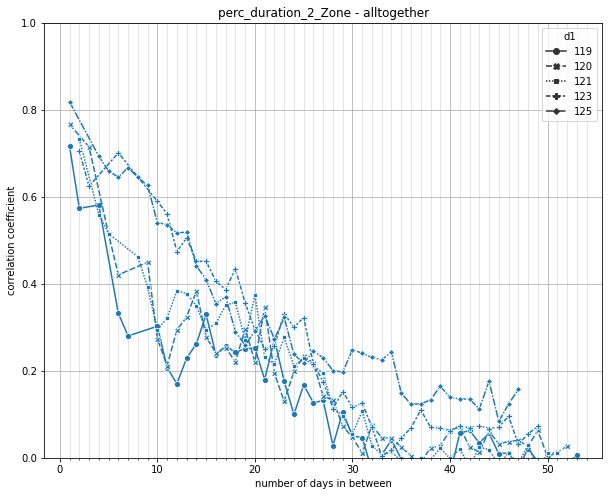

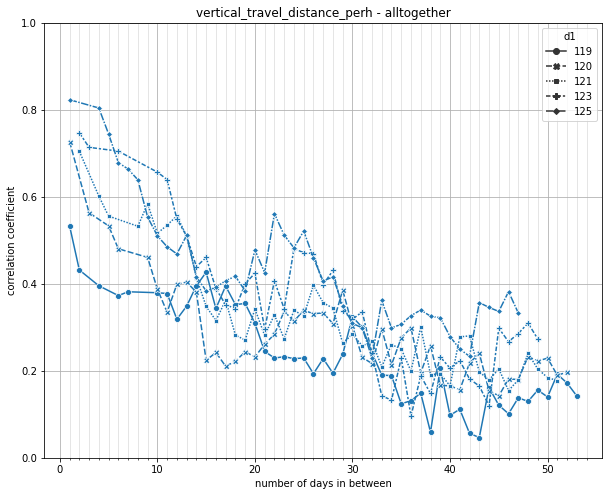

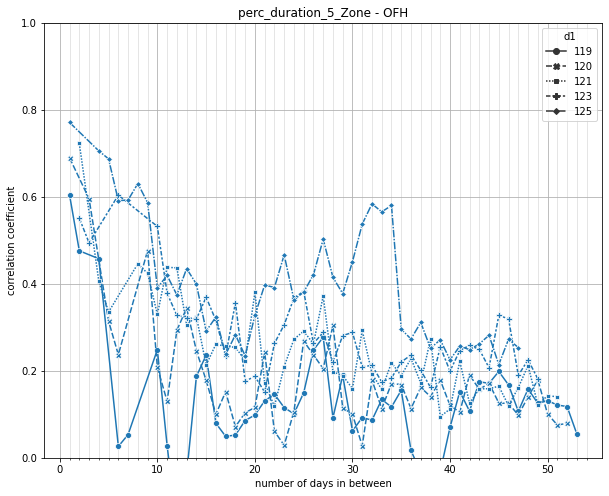

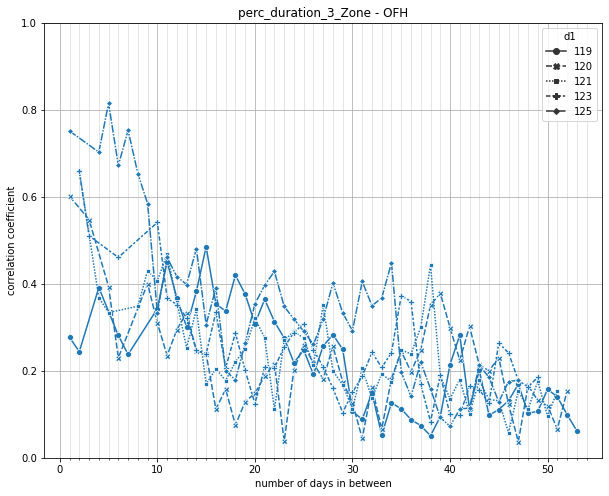

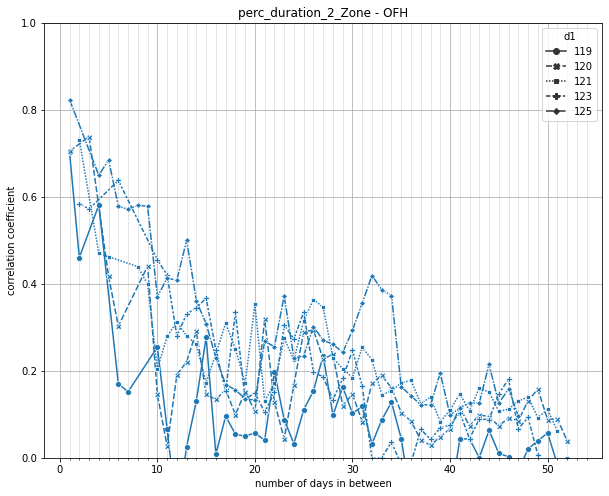

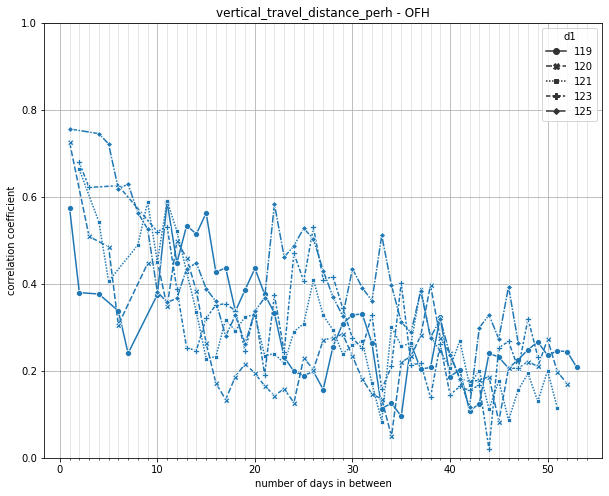

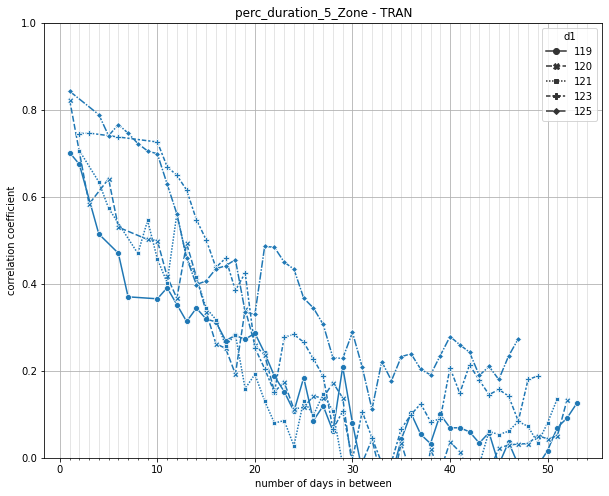

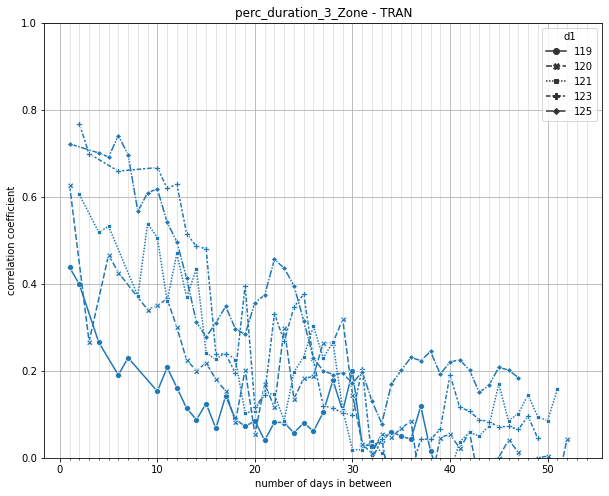

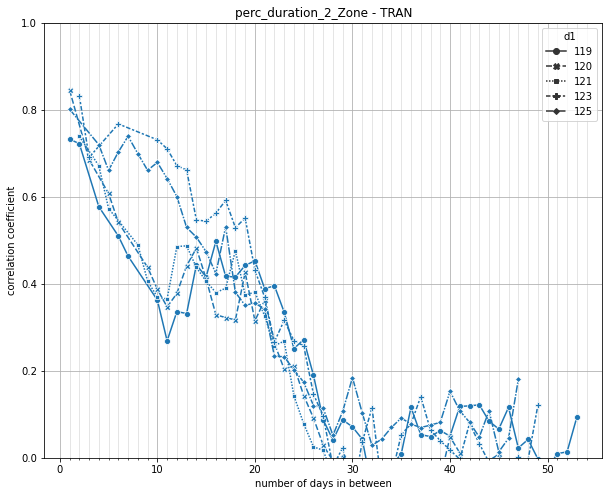

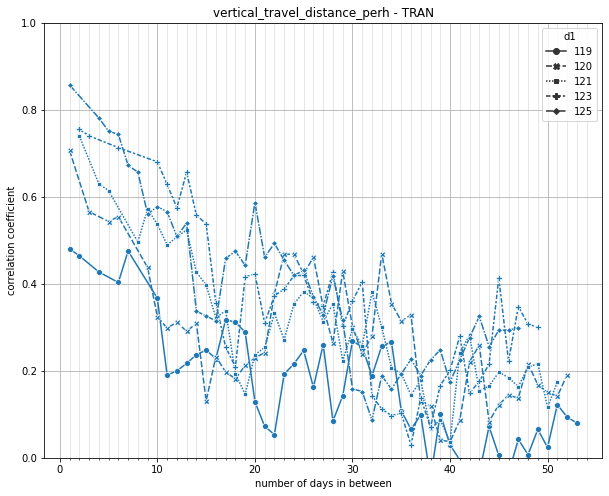

In [21]:
#nbr of "starting days" to be involved
nbr_starting_days = 7
for tr in df_corrddx['treatment'].unique():
    for type_ in df_corrddx['type_'].unique():
        fig = plt.figure(figsize=(10,8))
        plt.grid()
        graph = sns.lineplot(x='diff', y='coeff_np', data=df_corrddx[(df_corrddx['d1']<(min(li_DOA)+nbr_starting_days))&\
                                                                  (df_corrddx['type_']==type_)&\
                                                                  (df_corrddx['treatment']==tr)], 
                             markers=True, style='d1', hue_order=list(range(119,min(li_DOA)+nbr_starting_days)));
        plt.xlabel('number of days in between')
        plt.ylabel('correlation coefficient')
        minor_ticks = np.arange(0, 55, 1)
        graph.set_xticks(minor_ticks, minor=True)
        graph.grid(which='minor', alpha=0.4)
        plt.title(type_+' - '+tr)
        plt.ylim((0,1))
        plt.savefig(os.path.join(path_extracted_data, 'CorrelationNP_Predictibility_MLPSdayx_MLPSdy_'+type_+'_'+tr+'.png'), dpi=300, format='png', 
                    bbox_inches='tight')
        plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


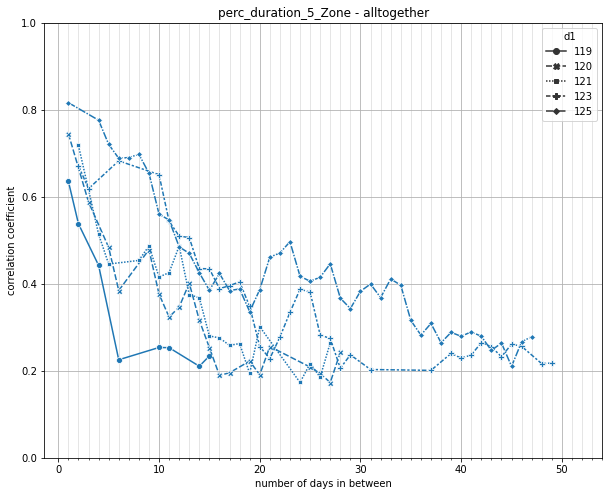

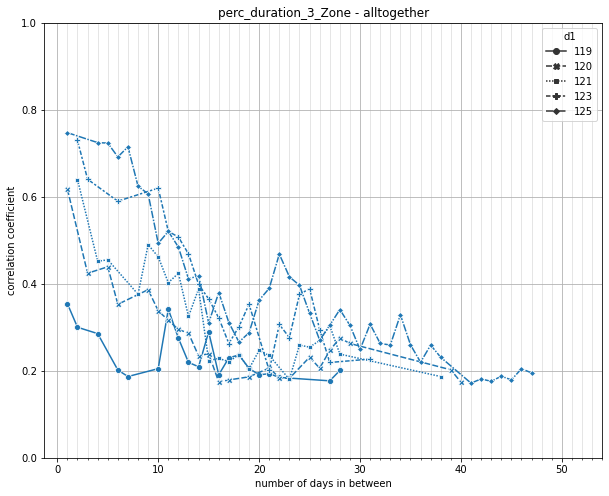

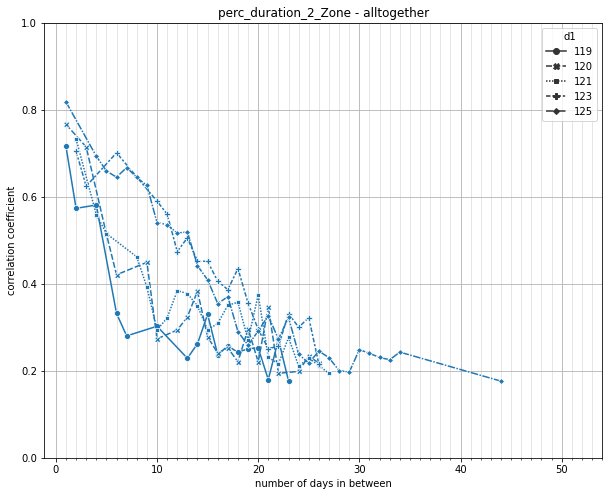

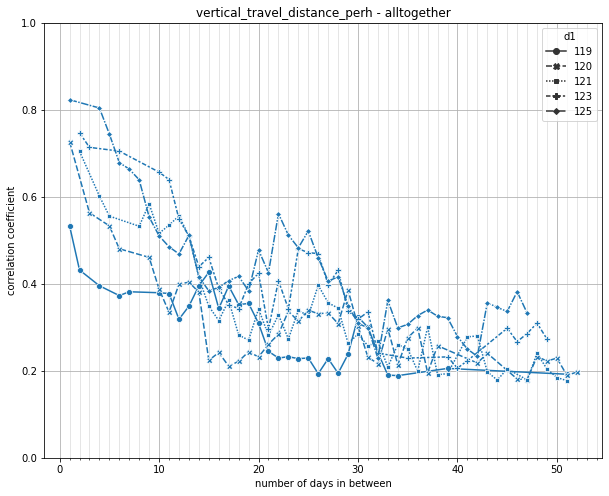

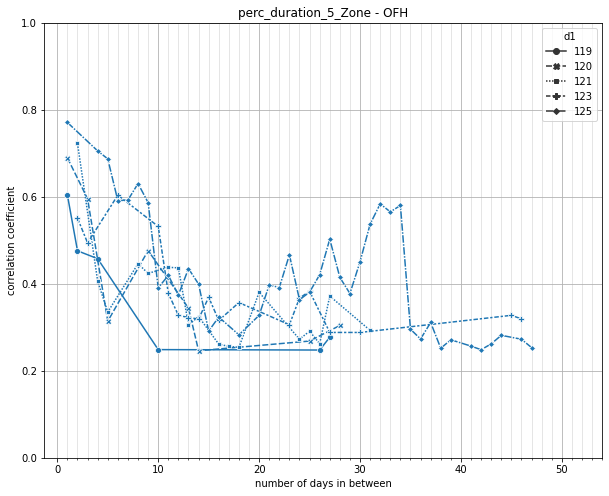

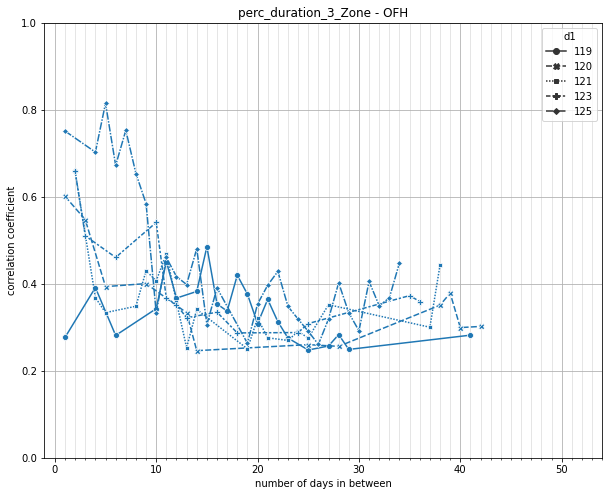

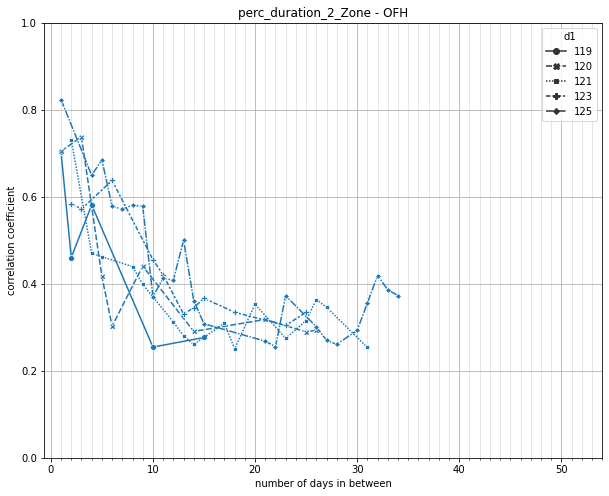

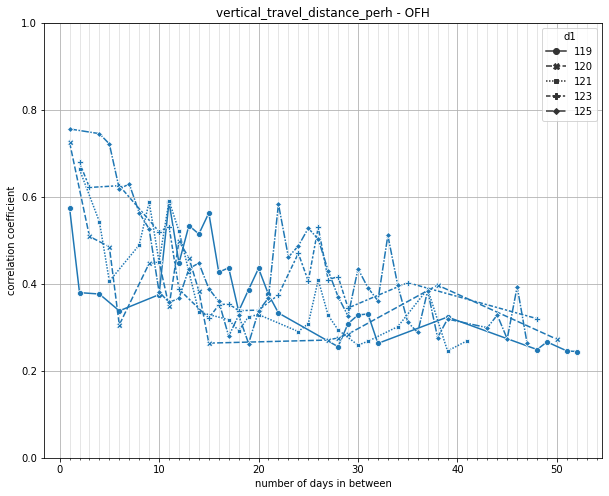

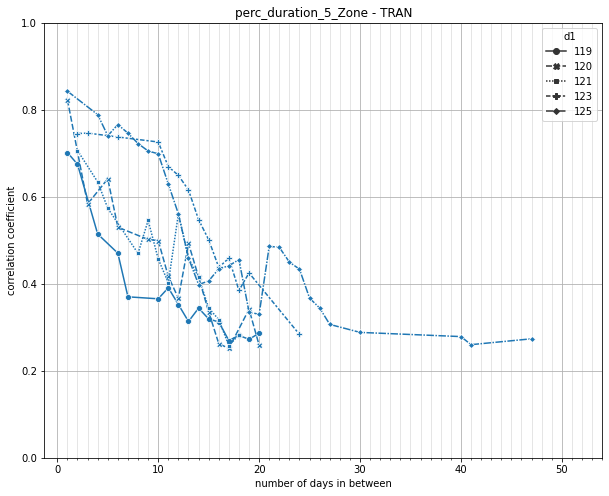

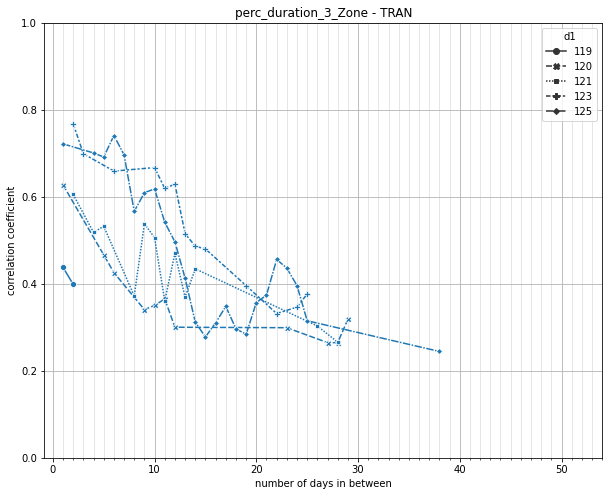

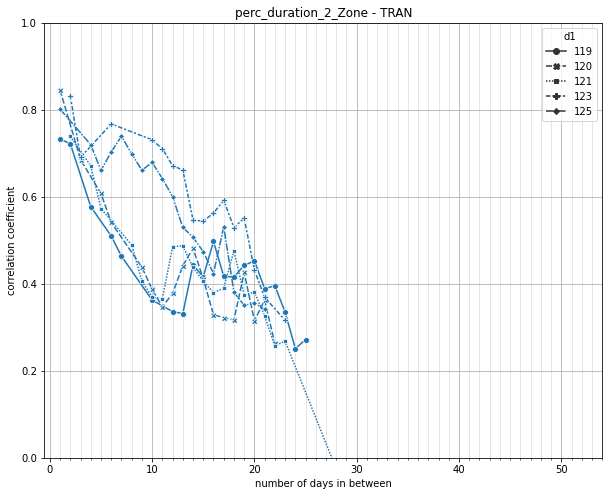

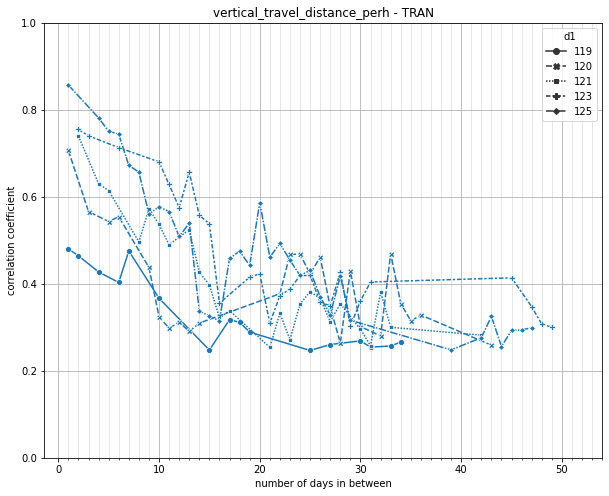

In [22]:
#nbr of "starting days" to be involved
nbr_starting_days = 7
for tr in df_corrddx['treatment'].unique():
    for type_ in df_corrddx['type_'].unique():
        fig = plt.figure(figsize=(10,8))
        plt.grid()
        graph = sns.lineplot(x='diff', y='coeff_np', data=df_corrddx[(df_corrddx['d1']<(min(li_DOA)+nbr_starting_days))&\
                                                                  (df_corrddx['type_']==type_)&\
                                                                  (df_coFFFFrrddx['treatment']==tr)&\
                                                                    (df_corrddx['p_val_np']<0.05)], 
                             markers=True, style='d1', hue_order=list(range(119,min(li_DOA)+nbr_starting_days)));
        plt.xlabel('number of days in between')
        plt.ylabel('correlation coefficient')
        minor_ticks = np.arange(0, 55, 1)
        graph.set_xticks(minor_ticks, minor=True)
        graph.grid(which='minor', alpha=0.4)
        plt.title(type_+' - '+tr)
        plt.ylim((0,1))
        plt.savefig(os.path.join(path_extracted_data, 'CorrelationNP_SIGN_Predictibility_MLPSdayx_MLPSdy_'+type_+'_'+tr+'.png'), dpi=300, format='png', 
                    bbox_inches='tight')
        plt.show()

In [23]:
df_test = df_corrddx[(df_corrddx['d1']==119)&(df_corrddx['type_']=='vertical_travel_distance_perh')&\
                     (df_corrddx['treatment']=='alltogether')&(df_corrddx['p_val_np']<0.05)]
df_test

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coeff,p_val,d1,d2,diff,type_,nbr_obs,coeff_np,p_val_np,L,H,verif,treatment,significant
10998,0.565483,1.962716e-12,119,120,1,vertical_travel_distance_perh,131,0.533563,5.315511e-11,0.436274,0.671843,"(0.5654828222308617, 1.9627156360826978e-12)",alltogether,True
11001,0.549209,1.102003e-11,119,121,2,vertical_travel_distance_perh,131,0.431916,2.589837e-07,0.416963,0.658684,"(0.5492093072319996, 1.102002949758e-11)",alltogether,True
11004,0.486643,3.269197e-07,119,123,4,vertical_travel_distance_perh,99,0.395597,5.061524e-05,0.319970,0.624098,"(0.48664286942070134, 3.269197044033207e-07)",alltogether,True
11007,0.492988,2.205392e-09,119,125,6,vertical_travel_distance_perh,131,0.373004,1.145384e-05,0.351157,0.612703,"(0.4929882204080572, 2.2053918001475055e-09)",alltogether,True
11010,0.491036,2.606803e-09,119,126,7,vertical_travel_distance_perh,131,0.381794,6.808041e-06,0.348896,0.611092,"(0.4910360613030486, 2.6068029713259423e-09)",alltogether,True
11013,0.345280,5.368606e-05,119,129,10,vertical_travel_distance_perh,131,0.379575,7.774344e-06,0.184693,0.487909,"(0.3452800707983488, 5.3686060261670004e-05)",alltogether,True
11016,0.364715,6.475582e-04,119,130,11,vertical_travel_distance_perh,84,0.377764,3.961860e-04,0.163071,0.537112,"(0.3647148676344279, 0.0006475582239831957)",alltogether,True
11019,0.309366,4.189850e-03,119,131,12,vertical_travel_distance_perh,84,0.318614,3.139046e-03,0.101717,0.491183,"(0.3093658647569399, 0.004189850304414712)",alltogether,True
11022,0.330511,2.136478e-03,119,132,13,vertical_travel_distance_perh,84,0.348648,1.153423e-03,0.124971,0.508849,"(0.3305105984686352, 0.00213647824021013)",alltogether,True
11025,0.380806,7.223266e-06,119,133,14,vertical_travel_distance_perh,131,0.395525,2.929353e-06,0.223906,0.518466,"(0.38080604644085836, 7.223265781589683e-06)",alltogether,True


In [8]:
path_adapt = os.path.join(path_extracted_data,'Adaptability')
df_res = pd.read_csv(os.path.join(path_adapt,'df_MVT_repeatibilityWIB.csv'), sep=',') 
df_res

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,li_R_org,li_CIL_org,li_CIU_org,li_P,li_se_org,li_ngroup,li_nobs,li_var,li_wib
0,1,0.559211,0.422544,0.671659,1.186302e-31,0.062089,52,312,perc_duration_5_Zone,1
1,2,0.450901,0.304632,0.563902,3.100812e-21,0.067244,52,312,perc_duration_3_Zone,1
2,3,0.577945,0.443744,0.682417,8.745185e-34,0.060428,52,312,perc_duration_2_Zone,1
3,4,0.699136,0.590715,0.782347,5.729824e-51,0.050052,52,312,vertical_travel_distance_perh,1
4,5,0.819892,0.740990,0.876055,2.429944e-61,0.035523,52,260,perc_duration_5_Zone,2
5,6,0.764721,0.657645,0.839857,5.815016e-50,0.046004,52,260,perc_duration_3_Zone,2
6,7,0.777948,0.678973,0.845811,2.088127e-52,0.043511,52,260,perc_duration_2_Zone,2
7,8,0.767440,0.660404,0.839016,1.880962e-50,0.045646,52,260,vertical_travel_distance_perh,2
8,9,0.822890,0.745086,0.875237,6.042862e-96,0.035010,52,362,perc_duration_5_Zone,3
9,10,0.725527,0.621196,0.806106,4.324526e-68,0.047037,52,362,perc_duration_3_Zone,3


In [10]:
df_res['li_var'] = df_res['li_var'].map(lambda x: x.replace('perc_duration_',
                                                            '% time spent in').replace('2_Zone',
                                                            'litter').replace('3_Zone','lower perch').replace('4_Zone',
                                                    'nestbox').replace('5_Zone','top floor'))
df_res = df_res.rename(columns={'li_var':'individual daily variables'})

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
df_res.to_csv(os.path.join(path_adapt,'df_MVT_repeatibilityWIB_p.csv'), index=False, sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
